In [1]:
import nibabel as nib
from PIL import Image

from sklearn.utils import shuffle
import glob

/Users/niyaz/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling 
        fr an isotropic unit Gaussian.

    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)

    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
TRAIN=[]
for path in glob.glob("../data/train/bladder/*"):  
    img  = np.array(Image.open(f'{path}').convert('1')).astype(np.uint8)
    TRAIN.append([img,1])

for path in glob.glob("../data/train/prostate/*"):
    img  = np.array(Image.open(f'{path}').convert('1')).astype(np.uint8)
    
    TRAIN.append([img,2])
    

TRAIN=shuffle(TRAIN, random_state=42)
TRAIN=np.asarray(TRAIN, dtype="object")

In [5]:
x_train=np.array(TRAIN[0:90,0].tolist())
y_train=np.array(TRAIN[0:90,1].tolist())

x_test=np.array(TRAIN[90:,0].tolist()) 
y_test=np.array(TRAIN[90:,1].tolist()) 

image_size = x_train.shape[1]

x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')

In [6]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 8
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 100

In [7]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        strides=2,
        padding='same'
    )(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

In [8]:
# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)

z_mean      = Dense(latent_dim, name='z_mean')(x)
z_log_var   = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary 
# with the TensorFlow backend
z = Lambda(sampling,output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [9]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# plot_model(encoder,to_file='vae_cnn_encoder.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 120, 120, 32)         320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 60, 60, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 230400)               0         ['conv2d_1[0][0]']            
                                                                                            

In [10]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3],activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [11]:
for i in range(2):
    x = Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        strides=2,
        padding='same'
    )(x)
    filters //= 2

In [12]:
outputs = Conv2DTranspose(
    filters=1,
    kernel_size=kernel_size,
    activation='sigmoid',
    padding='same',
    name='decoder_output'
)(x)


In [13]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder,to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 230400)            691200    
                                                                 
 reshape (Reshape)           (None, 60, 60, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 120, 120, 64)      36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 240, 240, 32)      18464     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 240, 240, 1)       289 

In [14]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("-w", "--weights", help="Load tf model trained weights")
    parser.add_argument("--bce", help="Use binary cross entropy instead of mse (default)", action='store_true')
    
    # args = parser.parse_args()
    
    args, unknown = parser.parse_known_args()

    models = (encoder, decoder)
    data   = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    if args.bce:
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
    else:
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
        

    reconstruction_loss *= image_size * image_size
    
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    vae.summary()
    
    # plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

    save_dir = "vae_cnn_weights"
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    if args.weights:
        filepath = os.path.join(save_dir, args.weights)
        vae = vae.load_weights(filepath)
    else:
        # train the autoencoder
        vae.fit(
            x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None)
        )
        filepath = os.path.join(save_dir, 'vae_cnn_mnist.tf')
        vae.save_weights(filepath)

# Incompatible shapes: [5715360] vs. [5625000]

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 240, 240, 1)]        0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  3705300   ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 240, 240, 1)          746881    ['encoder[0][2]']             
                                                                                                

In [15]:
encoder, decoder = models
x_test, y_test   = data
    
z, _, _ = encoder.predict(x_test,batch_size=batch_size)

3/3 [==============================] - 0s 6ms/step


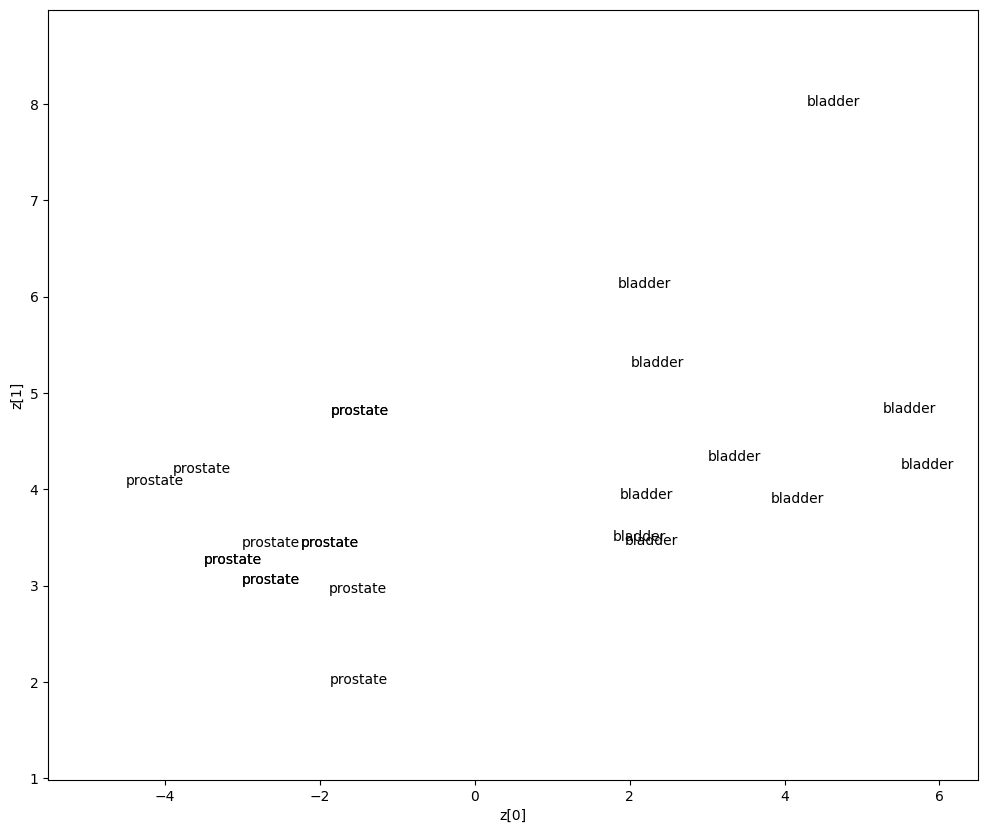

In [16]:
def first_plot(z,y_test):
    
    
    plt.figure(figsize=(12, 10))

    axes = plt.gca()
    axes.set_xlim([z[:, 0].min()-1,z[:, 0].max()+1])
    axes.set_ylim([z[:, 1].min()-1,z[:, 1].max()+1])
    
    plt.scatter(z[:, 0], z[:, 1], marker="")
    
    for i, organ in enumerate(y_test):
        axes.annotate(("bladder" if organ==1 else "prostate"), (z[i, 0], z[i, 1]))
        
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

first_plot(z,y_test)

1/1 [==============================] - 0s 18ms/step


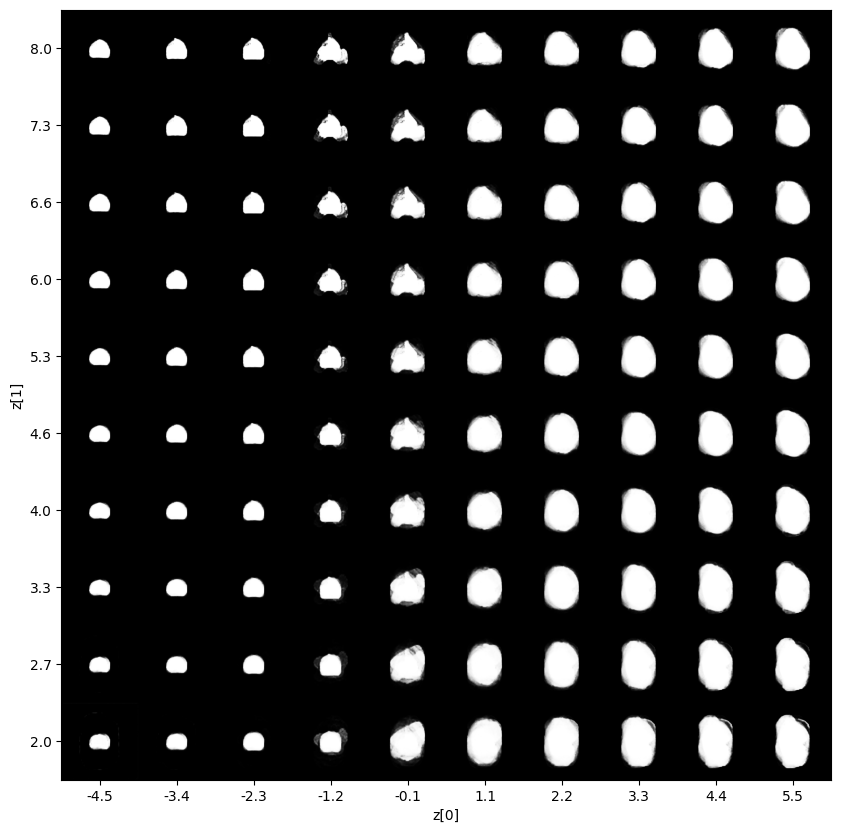

In [17]:
def second_plot(decoder,z):
    # filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    
    n = 10
    digit_size = 240
    
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(z[:, 0].min(),z[:, 0].max(), n)
    grid_y = np.linspace(z[:, 1].min(),z[:, 1].max(), n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            
            z_sample    = np.array([[xi, yi]])
            
            x_decoded   = decoder.predict(z_sample)
            
            digit       = x_decoded[0].reshape(digit_size, digit_size)
            
            figure[i * digit_size: (i + 1) * digit_size,   j * digit_size: (j + 1) * digit_size] = digit


    plt.figure(figsize=(10, 10))
    
    start_range = digit_size // 2
    end_range   = n * digit_size + start_range + 1
    
    # orignal source code [end_range-1] is [end_range] I added this [-1]
    pixel_range = np.arange(start_range, end_range-1, digit_size)
    
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    # plt.savefig(filename)
    plt.show()

second_plot(decoder,z)